In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
output_notebook()

Loading BokehJS ...

On commence par charger la vraie population

In [2]:
import os.path
outdir="../datarep"
pop_saq = pd.read_csv( os.path.join(outdir,"pop.csv") )
pop_tot = pop_saq['pop'].sum()

/home/tguyet/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Cas de la simulation pour les départements 83 et 13
"""
conn = sqlite3.connect("snds_8313.db")
dpt1="83"
dpt2="13"
"""
"""
# Cas de la simulation pour les départements 22 et 35
conn = sqlite3.connect("snds_2235.db")
dpt1="22"
dpt2="35"
"""

'\n# Cas de la simulation pour les départements 22 et 35\nconn = sqlite3.connect("snds_2235.db")\ndpt1="22"\ndpt2="35"\n'

In [4]:
conn = sqlite3.connect("snds_8313.db")
dpt1="83"
dpt2="13"

## Comparaison des répartitions de population

In [5]:
# On effectue une requête pour extraire les informations sur la population
df = pd.read_sql_query("SELECT BEN_SEX_COD, BEN_RES_DPT, BEN_NAI_ANN, count(*) FROM IR_BEN_R GROUP BY BEN_SEX_COD, BEN_RES_DPT, BEN_NAI_ANN;", conn)
df.rename(columns={'BEN_SEX_COD':'sex','BEN_RES_DPT':'dpt', 'count(*)':'count'}, inplace=True)
df['age']=2019-df.BEN_NAI_ANN
df=df[['sex','dpt','age','count']]

### Comparaison des ages

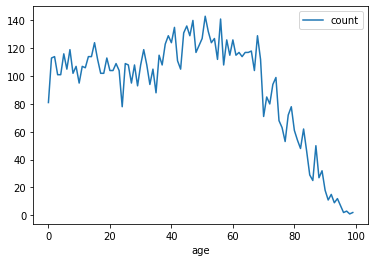

In [6]:
df_age=df.groupby(["age"]).agg({"count":"sum"}).reset_index()
df_age.plot(x='age',y="count")

In [7]:
#Besoin de faire des aggrégats pour comparer
age_bins=list(np.arange(0,100,5))
age_bins.append(125)
df_age['bin']=pd.cut(df_age.age,bins=age_bins,include_lowest=True, labels=age_bins[:-1])
df_age_agg=df_age.groupby('bin').agg({"count":"sum"}).reset_index()
df_age_agg.head()

,bin,count
0,0,626
1,5,528
2,10,565
3,15,533
4,20,504


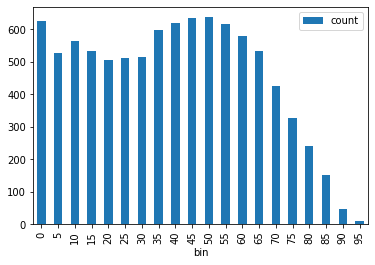

In [8]:
df_age_agg.plot.bar(x='bin',y="count")


In [9]:
pop_seq_dpt=pop_saq[ (pop_saq['dpt']==dpt1) | (pop_saq['dpt']==dpt2)].groupby(['age']).agg({'pop':'sum'}).reset_index()

In [10]:
#on ramène la population
ratio = sum(df_age_agg['count'])/sum(pop_seq_dpt['pop'])
pop_seq_dpt['pop'] *= ratio

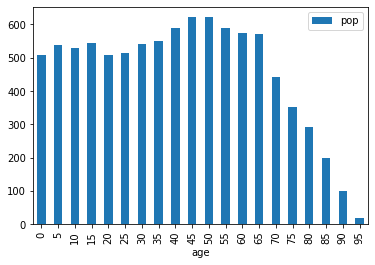

In [11]:
pop_seq_dpt.plot.bar(x="age",y="pop")

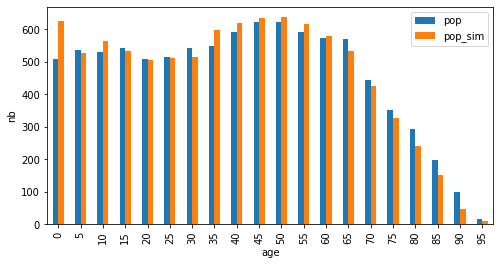

In [12]:
#On construit finalement un beau graphiques
pops=pd.merge(pop_seq_dpt, df_age_agg, left_on="age", right_on="bin")[['age','pop','count']].rename(columns={'count':'pop_sim'})

fig, axs = plt.subplots(figsize=(8,4))
pops.set_index("age").plot.bar(ax=axs)
axs.set_ylabel("nb")
fig.savefig("pop_age_"+str(dpt1)+str(dpt2)+".svg")

In [13]:
# calcul de la difference absolue relative "globale"
print( np.sum(np.abs(pops['pop_sim']-pops['pop']))/np.sum(pops['pop']) )
#calcul de la différente relative moyenne (entâchée à cause de grosses différences relatives aux extreminées notamment chez les vieux!!)
print( np.mean(np.abs(pops['pop_sim']-pops['pop'])/pops['pop']) )

0.06316212312922018
0.11321244653837718


### On fait maintenant pour les sexes
Dans ce cas, c'est plus simple ... il n'y a pas de binarisation des âges à faire

In [14]:
df_sex=df.groupby(["sex"]).agg({"count":"sum"}).reset_index()
df_sex

,sex,count
0,1,4393
1,2,4808


In [15]:
pop_sex_dpt=pop_saq[ (pop_saq['dpt']==dpt1) | (pop_saq['dpt']==dpt2)].groupby(['sex']).agg({'pop':'sum'}).reset_index()
pop_sex_dpt

,sex,pop
0,1,1.473403e+06
1,2,1.599484e+06


In [16]:
#on ramène la population
pop_sex_dpt['pop'] = ratio*pop_sex_dpt['pop']
#on merge les jeux de données
pops_sex=pd.merge(pop_sex_dpt,df_sex,on='sex').rename(columns={"count":"pop_sim"})

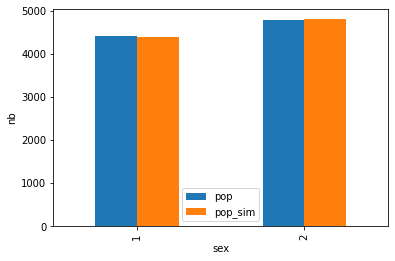

In [17]:
fig, axs = plt.subplots()
pops_sex.set_index("sex").plot.bar(ax=axs)
axs.set_ylabel("nb")
fig.savefig("pop_sex_"+str(dpt1)+str(dpt2)+".svg")

## On passe maintenant à une comparaison des distributions de médicaments

In [18]:
# On effectue une requête pour extraire les informations sur les médicaments (nombres de prescriptions par ATC 3)
# -> là on a les chiffres généré pour 2 départements, sur 1 an
df = pd.read_sql_query("SELECT PHA_ATC_C03, sum(PHA_ACT_QSN) FROM er_pha_f JOIN ir_pha_r ON ir_pha_r.PHA_CIP_C13=er_pha_f.PHA_PRS_C13 GROUP BY PHA_ATC_C03;", conn)
df.rename(columns={'PHA_ATC_C03':'ATC2','sum(PHA_ACT_QSN)':'nb'}, inplace=True)
df

,ATC2,nb
0,A01,4378
1,A02,16461
2,A03,8951
3,A04,1438
4,A05,428
...,...,...
73,S02,1065
74,V01,50
75,V03,174
76,V04,89


In [19]:
# données pour toute la population française, sur 1 an
data = pd.read_csv("../data/OPEN_MEDIC_2019.zip", header=0, sep=';', encoding="latin_1")[['ATC2','BOITES']]
data = data.groupby("ATC2").agg({'BOITES':'sum'}).reset_index().rename(columns={'BOITES':"nb"})

In [20]:
data.head()

,ATC2,nb
0,A01,22941566
1,A02,100746397
2,A03,48505314
3,A04,8452671
4,A05,1954634


In [21]:
#on calcule le ratio pour se ramener à des populations comparables
ratio = sum( df_age_agg['count'] )/pop_tot

In [22]:
df_cmp=pd.merge(data,df,how="left",on='ATC2',suffixes=('','_sim')).fillna(0)
df_cmp['nb'] *= ratio
df_cmp.head()

,ATC2,nb,nb_sim
0,A01,3180.935342,4378.0
1,A02,13968.870946,16461.0
2,A03,6725.446186,8951.0
3,A04,1171.994968,1438.0
4,A05,271.017435,428.0


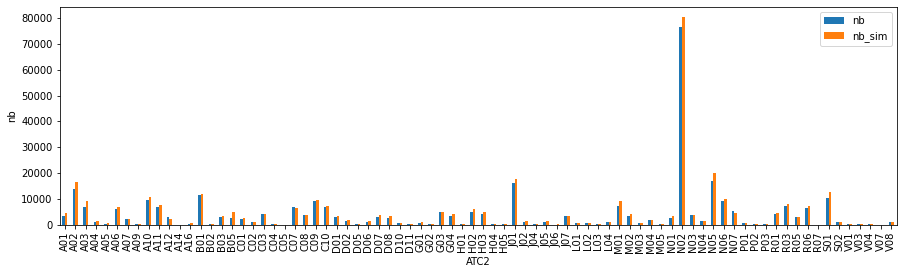

In [23]:
fig, axs = plt.subplots(figsize=(15, 4))
df_cmp.set_index("ATC2").plot.bar(ax=axs)
axs.set_ylabel("nb")
fig.savefig("ATC2_"+str(dpt1)+str(dpt2)+".svg")

In [24]:
# calcul de la difference absolue relative "globale"
print( np.sum(np.abs(df_cmp['nb_sim']-df_cmp['nb']))/np.sum(df_cmp['nb']) )
#calcul de la différente relative moyenne (entâchée à cause de grosses différences relatives aux extreminées notamment chez les vieux!!)
print( np.mean(np.abs(df_cmp['nb_sim']-df_cmp['nb'])/df_cmp['nb']) )

0.1252246520517605
0.22529974399859531


## Même chose pour les actes CCAM

In [25]:
# On effectue une requête pour extraire les informations sur les médicaments (nombres de prescriptions par ATC 3)
# -> là on a les chiffres généré pour 2 départements, sur 1 an
df = pd.read_sql_query("SELECT CAM_PRS_IDE, CAM_PRS_RGT, count(*) FROM er_cam_f JOIN ir_ccam_v63 ON er_cam_f.CAM_PRS_IDE=ir_ccam_v63.CAM_PRS_IDE_COD GROUP BY CAM_PRS_IDE, CAM_PRS_RGT;", conn)
df.rename(columns={'CAM_PRS_IDE':'ccam','CAM_PRS_RGT':'grp','count(*)':'nb'}, inplace=True)
df

,ccam,grp,nb
0,AAQM002,ADE,3
1,ACQH001,ADI,1
2,ACQH002,ADI,1
3,ACQH003,ADI,36
4,ACQH004,ADI,1
...,...,...,...
509,ZZQL018,ADI,2
510,ZZQL019,ADI,2
511,ZZQM001,ADE,1
512,ZZQM004,ADE,1


In [26]:
actes = pd.read_excel("../data/Actes_techniques_de_la_CCAM_en_2016.xls", sheet_name='Panorama des actes CCAM')
actes.rename(columns={"Code Acte":'ccam',"Code Regroupement":"grp", "Quantité d'actes ":"nb"}, inplace=True)
actes=actes.groupby(['ccam',"grp"]).agg({"nb":"sum"}).reset_index()

In [27]:
#sélection des actes qui sont effectivement utilisés dans la simulation
actes=actes[ (actes['grp']=="ADC") | (actes['grp']=="ACO") |(actes['grp']=="ADA") |(actes['grp']=="ADE") |(actes['grp']=="ADI") |(actes['grp']=="ADT") ]
actes=actes[ (actes['ccam'].str[:2]!="HB") ]

In [28]:
actes.head()

,ccam,grp,nb
0,AAFA001,ADA,93
1,AAFA001,ADC,103
2,AAFA002,ADA,382
3,AAFA002,ADC,446
4,AAFA003,ADA,9


In [29]:
actes_tot=actes.groupby(['ccam']).agg({"nb":"sum"}).reset_index()

In [30]:
actes_tot.head()

,ccam,nb
0,AAFA001,196
1,AAFA002,828
2,AAFA003,18
3,AAFA005,17
4,AAFA006,4


In [31]:
actes_tot['nb'] *= ratio

In [32]:
actes_tot.head()

,ccam,nb
0,AAFA001,0.027176
1,AAFA002,0.114805
2,AAFA003,0.002496
3,AAFA005,0.002357
4,AAFA006,0.000555


In [33]:
actes_grp=actes.groupby(['grp']).agg({"nb":"sum"}).reset_index()
actes_grp['nb'] *= ratio

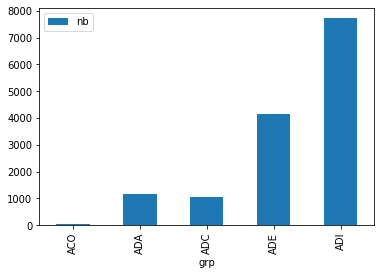

In [34]:
actes_grp.set_index("grp").plot.bar()

In [35]:
df_grp=df.groupby("grp").agg({"nb":"sum"}).reset_index()

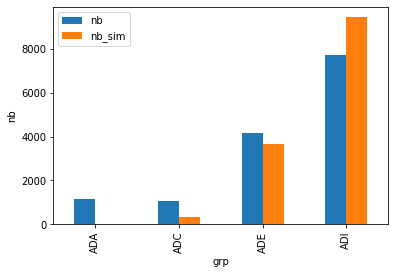

In [36]:
grps=pd.merge(actes_grp, df_grp,on="grp", suffixes=('','_sim'))

fig, axs = plt.subplots()
grps.set_index("grp").plot.bar(ax=axs)
axs.set_ylabel("nb")
fig.savefig("ccam_grp_"+str(dpt1)+str(dpt2)+".svg")

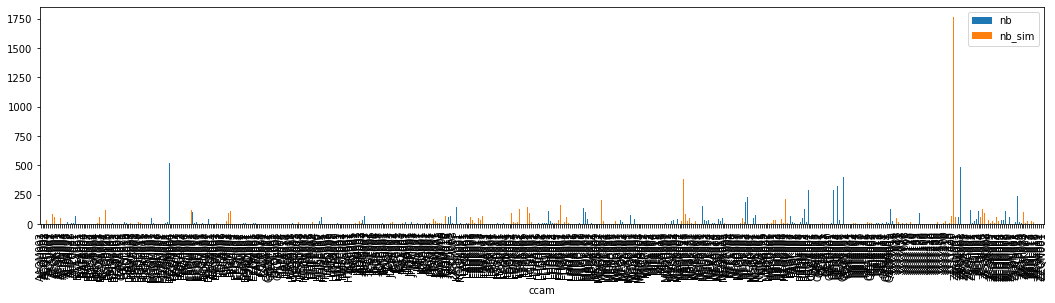

In [37]:
actes_ccam=actes.groupby(['ccam']).agg({"nb":"sum"}).reset_index()
actes_ccam['nb'] *= ratio
actes_ccam['nb'] = actes_ccam['nb'].astype(int)
df_ccam=df.groupby("ccam").agg({"nb":"sum"}).reset_index()
ccams=pd.merge(actes_ccam, df_ccam, on="ccam", suffixes=('','_sim'))
ccams.set_index("ccam").plot.bar(figsize=(18,4))

In [38]:
ccams['r']=(ccams['nb']-ccams['nb_sim'])/ccams['nb']

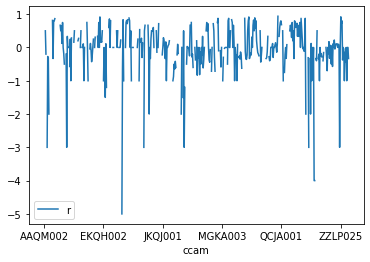

In [39]:
ccams.plot(x='ccam',y='r')

In [40]:
ccams['r'].describe()

count    514.000000
mean           -inf
std             NaN
min            -inf
25%       -2.000000
50%       -0.139610
75%        0.172101
max        0.937500
Name: r, dtype: float64

In [41]:
ccams['r'].dropna().mean()

-inf

In [42]:
ccams['nb'].describe()

count     514.000000
mean       25.138132
std        84.507439
min         0.000000
25%         1.000000
50%         4.000000
75%        17.000000
max      1488.000000
Name: nb, dtype: float64

In [43]:
p = figure(title=None, x_range=ccams['ccam'].to_numpy(), y_range=(0,1200), plot_width=1200, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x='ccam', top='nb', source=ColumnDataSource(ccams), width=0.5)
p.vbar(x='ccam', top='nb_sim', fill_color="orange", width=0.5, source=ColumnDataSource(ccams))
show(p)

In [44]:
# calcul de la difference absolue relative "globale"
print( np.sum(np.abs(ccams['nb_sim']-ccams['nb']))/np.sum(ccams['nb']) )
#calcul de la différente relative moyenne 
print( np.mean(np.abs(ccams['nb_sim']-ccams['nb'])/ccams['nb']) )

0.2700255398188995
inf
